In [62]:
# Download the corresponding PyTorch Geometric module
%%capture
"""
Assign to TORCH with what you get from the cell above, E.g., export TORCH=1.13.1+cu113
"""
%env TORCH=2.1.0+cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [63]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool,global_max_pool
import random
import numpy as np



In [64]:
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [65]:
# Load ENZYMES, MUTAG dataset
set_seed(1)
dataset = TUDataset(root='data/TUDataset', name='MUTAG', use_node_attr=True)
dataset = dataset.shuffle()
shuffled_indices = [data.y.item() for data in dataset]
print(shuffled_indices[:10])


# Train/test split (80/20)
split_idx = int(0.8 * len(dataset))
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


[1, 0, 0, 1, 1, 1, 0, 0, 0, 1]


In [66]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim, cached=False)
        self.conv2 = GCNConv(hidden_dim, hidden_dim, cached=False)
        self.lin = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.3, training=self.training)
        x = global_max_pool(x, batch)  # Aggregate node features
        x = self.lin(x)
        return x.view(-1)

    def get_ebd(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x


def train():
    model.train()
    criterion = torch.nn.BCEWithLogitsLoss()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation
@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = (torch.sigmoid(out) > 0.5).long()
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

def reset_weights(m):
    if isinstance(m, (torch.nn.Linear, GCNConv)):
        m.reset_parameters()


In [67]:
# Train for a few epochs
model = GCN(input_dim=dataset.num_node_features,
            hidden_dim=64).to(device)
model.apply(reset_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)

num_epochs = 80
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    if epoch % 20 == 0:
      print(f"Epoch {epoch:02d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 00, Loss: 0.6121, Train Acc: 0.6933, Test Acc: 0.5526
Epoch 20, Loss: 0.5033, Train Acc: 0.7800, Test Acc: 0.6842
Epoch 40, Loss: 0.4984, Train Acc: 0.7867, Test Acc: 0.6842
Epoch 60, Loss: 0.4859, Train Acc: 0.7667, Test Acc: 0.7105


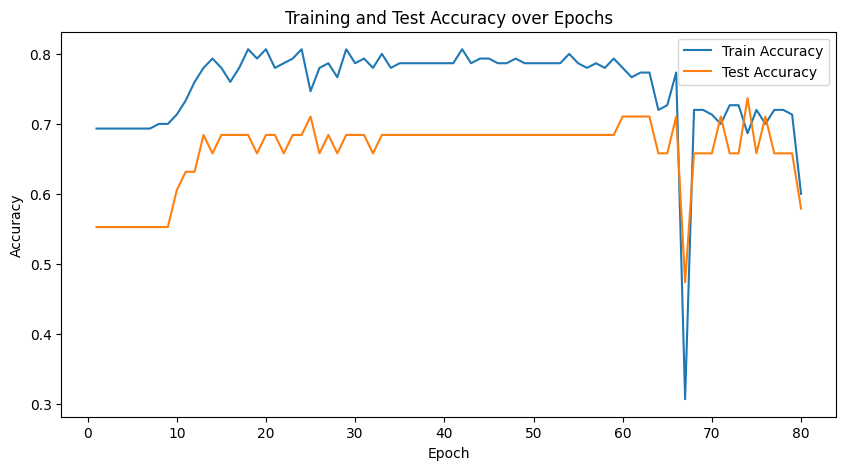

In [68]:
# Plot the training and test accuracy curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()

In [69]:
from scipy.optimize import root_scalar
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
import time
from time import sleep
from copy import deepcopy
from torch_geometric.utils import to_dense_adj
from Perturbe_Algs import Attacks


In [70]:
random_dataset = [deepcopy(data) for data in test_dataset]
pgdavg_dataset = [deepcopy(data) for data in test_dataset]
pgdwst_dataset = [deepcopy(data) for data in test_dataset]

for i in tqdm(range(len(test_dataset))):
    data = test_dataset[i].to(device)
    edge_index = data.edge_index
    dataA = to_dense_adj(edge_index)[0].clone()
    K = (data.x) @ (data.x).T
    if dataA.shape[0] == data.x.shape[0]:
      n = dataA.shape[0]
      num = int(n*n*0.05)
      attack_instance = Attacks(dataA, K, m=num, filter = 'adj_norm_self_loop').to(device)

      A_pgd_avg = attack_instance.Prob_PGD().clone().detach()
      A_pgd_wst = attack_instance.Wst_PGD().clone().detach()
      A_random = attack_instance.randomAttack().clone().detach()
    else:
      print('Miss matched data: no operation')
      A_pgd_avg = dataA.clone().detach()
      A_pgd_wst = dataA.clone().detach()
      A_random = dataA.clone().detach()

    random_edge_index = torch.tensor(A_random).nonzero(as_tuple=False).t().contiguous()
    pgdavg_edge_index = torch.tensor(A_pgd_avg).nonzero(as_tuple=False).t().contiguous()
    pgdwst_edge_index = torch.tensor(A_pgd_wst).nonzero(as_tuple=False).t().contiguous()

    random_dataset[i].edge_index = random_edge_index
    pgdavg_dataset[i].edge_index = pgdavg_edge_index
    pgdwst_dataset[i].edge_index = pgdwst_edge_index

  0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-70-af61cbecb826>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_edge_index = torch.tensor(A_random).nonzero(as_tuple=False).t().contiguous()
<ipython-input-70-af61cbecb826>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pgdavg_edge_index = torch.tensor(A_pgd_avg).nonzero(as_tuple=False).t().contiguous()
<ipython-input-70-af61cbecb826>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pgdwst_edge_index = torch.tensor(A_pgd_wst).nonzero(as_tuple=False).t().contiguous()


In [71]:
rep_num = 10
list_acc_pgdavg = []
list_acc_pgdwst = []
list_acc_random = []
list_acc = []
list_embed_pgdavg = []
list_embed_pgdwst = []
list_embed_random = []

for l in range(rep_num):

  embed_pgdavg = []
  embed_pgdwst = []
  embed_random = []

  # Re-train model in repeating experiment
  model.apply(reset_weights)
  num_epochs = 50
  for epoch in range(num_epochs):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

  model.eval()
  for i in (range(len(test_dataset))):
    data = test_dataset[i].to(device)
    avg_data = pgdavg_dataset[i].to(device)
    wst_data = pgdwst_dataset[i].to(device)
    random_data = random_dataset[i].to(device)
    with torch.no_grad():
      ebd_test = model.get_ebd(data.x, data.edge_index)
      ebd_pgd_avg = model.get_ebd(data.x, avg_data.edge_index )
      ebd_pgd_wst = model.get_ebd(data.x, wst_data.edge_index)
      ebd_random = model.get_ebd(data.x, random_data.edge_index)

      embed_pgdavg.append(torch.norm(ebd_test - ebd_pgd_avg, p = 'fro'))
      embed_pgdwst.append(torch.norm(ebd_test - ebd_pgd_wst, p = 'fro'))
      embed_random.append(torch.norm(ebd_test - ebd_random, p = 'fro'))

  pgdavg_test_loader = DataLoader(pgdavg_dataset, batch_size=len(pgdavg_dataset), shuffle=False)
  pgdwst_test_loader = DataLoader(pgdwst_dataset, batch_size=len(pgdwst_dataset), shuffle=False)
  random_test_loader = DataLoader(random_dataset, batch_size=len(random_dataset), shuffle=False)

  list_embed_pgdavg.append(sum(embed_pgdavg).item()/len(test_dataset))
  list_embed_pgdwst.append(sum(embed_pgdwst).item()/len(test_dataset))
  list_embed_random.append(sum(embed_random).item()/len(test_dataset))

  print(f"-----Iteration {l:d}-----")
  print(f"Test Acc: {test_acc:.4f}")
  list_acc.append(test_acc)
  pgdavg_test_acc = test(pgdavg_test_loader)
  list_acc_pgdavg.append(pgdavg_test_acc)
  print(f"PGD-AVG Test Acc: {pgdavg_test_acc:.4f}")

  pgdwst_test_acc = test(pgdwst_test_loader)
  list_acc_pgdwst.append(pgdwst_test_acc)
  print(f"PGD-WST Test Acc: {pgdwst_test_acc:.4f}")

  random_test_acc = test(random_test_loader)
  list_acc_random.append(random_test_acc)
  print(f"Random Test Acc: {random_test_acc:.4f}")


-----Iteration 0-----
Test Acc: 0.7105
PGD-AVG Test Acc: 0.4211
PGD-WST Test Acc: 0.6842
Random Test Acc: 0.7105
-----Iteration 1-----
Test Acc: 0.6842
PGD-AVG Test Acc: 0.3947
PGD-WST Test Acc: 0.6579
Random Test Acc: 0.7368
-----Iteration 2-----
Test Acc: 0.6842
PGD-AVG Test Acc: 0.3947
PGD-WST Test Acc: 0.6842
Random Test Acc: 0.7368
-----Iteration 3-----
Test Acc: 0.6579
PGD-AVG Test Acc: 0.3947
PGD-WST Test Acc: 0.6842
Random Test Acc: 0.7368
-----Iteration 4-----
Test Acc: 0.6842
PGD-AVG Test Acc: 0.4211
PGD-WST Test Acc: 0.7105
Random Test Acc: 0.7368
-----Iteration 5-----
Test Acc: 0.7105
PGD-AVG Test Acc: 0.5263
PGD-WST Test Acc: 0.6842
Random Test Acc: 0.7105
-----Iteration 6-----
Test Acc: 0.6842
PGD-AVG Test Acc: 0.3947
PGD-WST Test Acc: 0.6579
Random Test Acc: 0.7368
-----Iteration 7-----
Test Acc: 0.7105
PGD-AVG Test Acc: 0.4211
PGD-WST Test Acc: 0.6842
Random Test Acc: 0.7105
-----Iteration 8-----
Test Acc: 0.6842
PGD-AVG Test Acc: 0.3947
PGD-WST Test Acc: 0.6842
Random 

In [72]:
print(f"Test: {np.mean(list_acc)*100:.2f}, std:{np.std(list_acc)*100:.2f}")
print(f"Mean of random: {np.mean(list_acc_random)*100:.2f}, std:{np.std(list_acc_random)*100:.2f}")
print(f"Mean of Wst_PGD: {np.mean(list_acc_pgdwst)*100:.2f}, std: {np.std(list_acc_pgdwst)*100:.2f}")
print(f"Mean of Prob_PGD:{np.mean(list_acc_pgdavg)*100:.2f}, std: {np.std(list_acc_pgdavg):.2f}")


Test: 68.95, std:1.58
Mean of random: 72.89, std:1.21
Mean of Wst_PGD: 68.16, std: 1.42
Mean of Prob_PGD:41.58, std: 0.04


In [73]:
print(f"Mean of random embedding norm: {np.mean(list_embed_random):.2f}, std:{np.std(list_embed_random):.2f}")
print(f"Mean of Wst_PGD embedding norm: {np.mean(list_embed_pgdwst):.2f}, std: {np.std(list_embed_pgdwst):.2f}")
print(f"Mean of Prob_PGD embedding norm:{np.mean(list_embed_pgdavg):.2f}, std: {np.std(list_embed_pgdavg):.2f}")

Mean of random embedding norm: 3.57, std:0.17
Mean of Wst_PGD embedding norm: 3.10, std: 0.16
Mean of Prob_PGD embedding norm:5.21, std: 0.25


<ipython-input-74-de5d6de50e7c>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


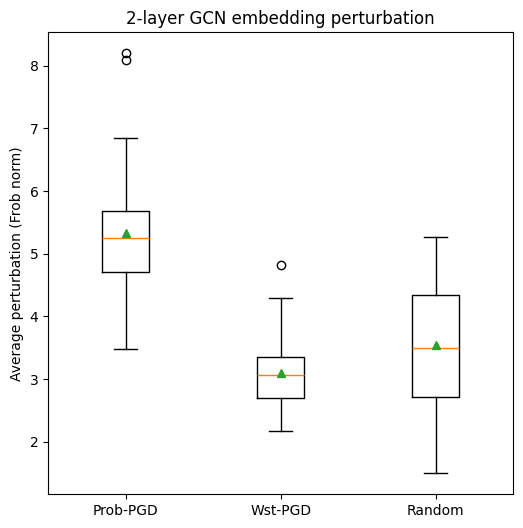

In [74]:
plt.figure(figsize=(6, 6))
plt.boxplot([
    [e.cpu() for e in embed_pgdavg],
    [e.cpu() for e in embed_pgdwst],
    [e.cpu() for e in embed_random]
], labels=['Prob-PGD', 'Wst-PGD', 'Random'],showmeans = True)
plt.ylabel('Average perturbation (Frob norm)')
plt.title('2-layer GCN embedding perturbation')
plt.show()

In [75]:
print(f"Test: {np.mean(list_acc)*100:.2f} \pm {np.std(list_acc)*100:.2f}")
print(f"Mean of random: {np.mean(list_acc_random)*100:.2f} \pm {np.std(list_acc_random)*100:.2f}")
print(f"Mean of Wst_PGD: {np.mean(list_acc_pgdwst)*100:.2f} \pm {np.std(list_acc_pgdwst)*100:.2f}")
print(f"Mean of Prob_PGD:{np.mean(list_acc_pgdavg)*100:.2f} \pm {np.std(list_acc_pgdavg):.2f}")
print(f"Mean of random embedding norm: {np.mean(list_embed_random):.2f} \pm {np.std(list_embed_random):.2f}")
print(f"Mean of Wst_PGD embedding norm: {np.mean(list_embed_pgdwst):.2f} \pm {np.std(list_embed_pgdwst):.2f}")
print(f"Mean of Prob_PGD embedding norm:{np.mean(list_embed_pgdavg):.2f} \pm {np.std(list_embed_pgdavg):.2f}")

Test: 68.95 \pm 1.58
Mean of random: 72.89 \pm 1.21
Mean of Wst_PGD: 68.16 \pm 1.42
Mean of Prob_PGD:41.58 \pm 0.04
Mean of random embedding norm: 3.57 \pm 0.17
Mean of Wst_PGD embedding norm: 3.10 \pm 0.16
Mean of Prob_PGD embedding norm:5.21 \pm 0.25
